# Clustering Centers and Scores
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script calcules the clusters centers and respective scores according to different simillarity measures:
- Euclidean
- DTW
- kMedoids-DTW

In [1]:
from dtaidistance.dtw_barycenter import dba_loop as dba_centre
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from tslearn.barycenters import euclidean_barycenter as euc_center

from dtaidistance.ed import distance as euc_dist
from dtaidistance.dtw import distance_fast as dtw_dist
from sktime.clustering.k_medoids import TimeSeriesKMedoids

In [21]:
import pandas as pd
import polars as pl
import numpy as np
import time
from tqdm.auto import tqdm
import os
from itertools import cycle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import Transform

---
# Script Variabels

In [3]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
solution_name = 'CNN_ConvEmb-vague_sweep_1_v41'

In [4]:
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'

sol_location = f'../ModelResults/Clustering/Solutions/{dataset_name}/{solution_name}.csv'

window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

---
# Data Imports

In [5]:
df_data = pl.read_csv(dataset_location)

---
# Ploting Functions

In [6]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [7]:
def plot_elbow(df_centers, alg = 'kMeans', mode = 'Total_Score', line_type = 'avg'):
    
    df = df_centers[df_centers['Algorithm'] == alg]
    
    if line_type == 'avg': 
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('mean').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        
    elif line_type == 'w_avg':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['Cluster_Size', 'k', mode]].groupby('k').apply(w_avg, mode, 'Cluster_Size').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        df_line.rename(columns={0: mode}, inplace=True)    
    
    elif line_type == 'sum':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('sum').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        
    
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=df[mode],
            x=df['k'],
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.5,
            fillcolor='rgba(93, 164, 214, 0.5)',
            marker_size=3,
            line_width=1.5,
        )
    )
        
    fig.add_trace(
        go.Scatter(
            x=df_line['k'],
            y=df_line[mode],
            mode = 'lines+markers',
            name = 'Average',
            marker_color='rgba(128, 0, 0, .6)'
        )
    )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = False
    )
    
    fig.show()

In [8]:
def plot_cluster_samples (df_centers, df_data, mode = 'Total_Score', alg = 'kMeans', k = 'k10', cluster = 1, sample = 10, seed = 42):
    
    df_center = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k) & (df_centers['cluster'] == cluster)]
    center = df_center[window_cols].values.ravel()
    
    sol = ('_').join([alg, k])    
    df_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == cluster).select(["short_ID", "window_ID"]).collect().sample(n=sample, seed=seed)  
    df_samples = df_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
    samples = df_samples[window_cols].values
    
    fig = go.Figure()
       
    # Samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(
                x = window_cols,
                y = sample,
                mode = 'lines',
                name = 'Average',
                marker_color='rgba(36, 37, 42, .25)',
                hoverinfo='skip'
            )
        )    
        
    # Center Line
    fig.add_trace(
        go.Scatter(
            x = window_cols,
            y = center,
            mode = 'lines',
            name = 'Cluster Center',
            line=dict(color='rgba(217, 30, 24, .8)', width=3.5),
            hovertemplate='%{y:.2f}',
        )
    )
 
    
    # Figure Style
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': f'<b>Cluster: {cluster}</b> - {alg}_{k}',
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()

In [9]:
def plot_centers(df_centers, alg = 'kMeans', k = 'k10'):
    
    df = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k)]
    sol_cols = pl.scan_csv(sol_location).columns[5:]

    max_c = int(sol_cols[-1].split('_')[-1][1:])

    fig = go.Figure()
    for c in range(1, max_c +1):
        fig.add_trace(
            go.Scatter(
                x=window_cols,
                y= df[df['cluster'] == c][window_cols].values.ravel(),
                mode='lines',
                name= f'Cluster: {c}'
            )
        )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = True 
    )


    fig.show()
    

In [10]:
def plot_flow(df_data, alg = 'kMeans', k = 'k10', sample = 1000, groupnorm = 'percent'):
    
    sol = ('_').join([alg, k])   
    if sample == 'all':
        df_ids = pl.scan_csv(sol_location).select(["short_ID", "window_ID", sol]).collect()
    else:
        df_ids = pl.scan_csv(sol_location).select(["short_ID", "window_ID", sol]).fetch(sample)  
        
    df = df_ids.join(df_data[['short_ID', 'window_ID', 'window_start_date']], on = ['short_ID', 'window_ID'], how='left').to_pandas()
    df = df[['short_ID', 'window_ID', 'window_start_date', sol]]

    df['window_start_date'] = pd.to_datetime(df['window_start_date'])   
    df = df.set_index('window_start_date').groupby('short_ID').resample('1D').mean().reset_index(level='short_ID', drop=True).astype('Int64', errors = 'ignore').reset_index().fillna(method='ffill')
    
    cmin = df[sol].min()
    cmax = df[sol].max()
    
    palette = cycle(px.colors.qualitative.T10)
    fig = go.Figure()
    for c in range(cmin, cmax+1):
        cluster_count = df[df[sol]==c].groupby('window_start_date')[sol].count()
    
        fig.add_trace(
            go.Scatter(
                x=cluster_count.index,
                y=cluster_count.values,
                fill='tonexty',
                mode= 'lines',
                name = f'Cluster: {c}',
                stackgroup = 'one',
                groupnorm=groupnorm,
                hovertemplate='%{y:.1f}',
                line=dict(width=0, color=next(palette))
            )
        )
        
    # Figure Style
    sol_name = solution_name.split('-')[0]
    if groupnorm == 'percent':
        graph_mode = 'Percentage'
    else:
        graph_mode = 'Total Count'
        
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="plotly_white",
        showlegend = True,
        legend = {
            'y': 0.5,
            'yanchor': 'middle',
        },
        hovermode = 'x',
        title={
            'text': f'{graph_mode}: <b>{sol_name} {alg} (k={k[1:]})</b>',
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )

    fig.show()

---
# Flow Charts

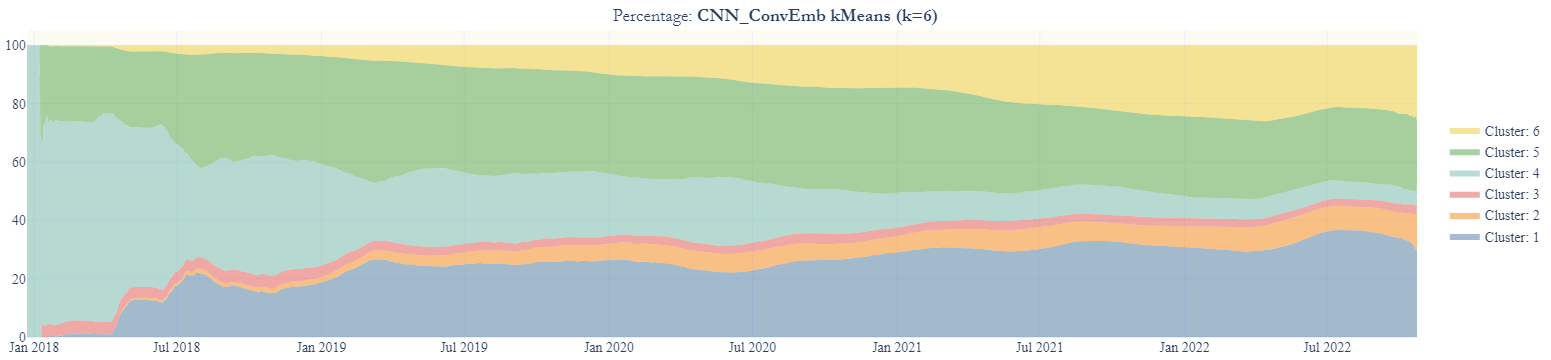

In [568]:
plot_flow(df_data, alg = 'kMeans', k='k6', groupnorm = 'percent', sample = 'all')

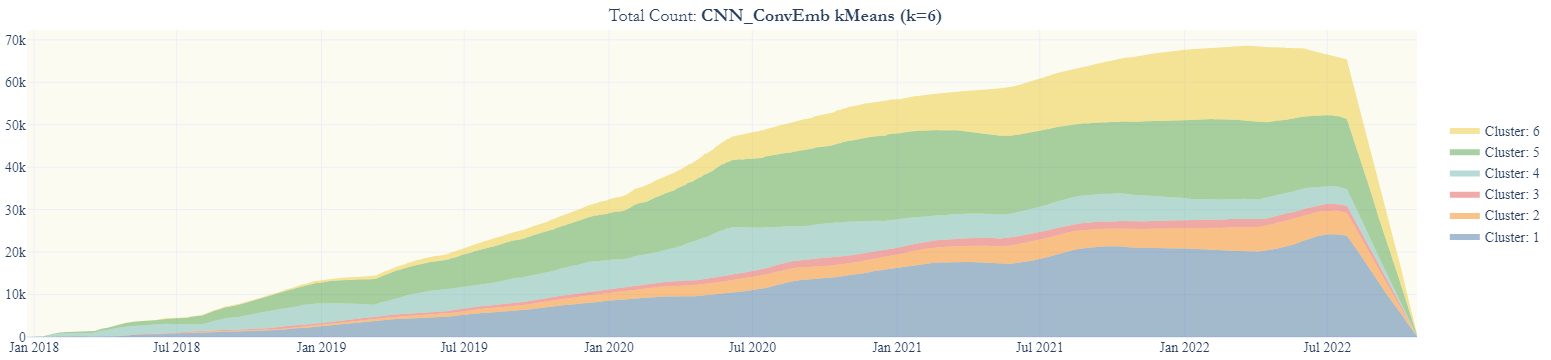

In [569]:
plot_flow(df_data, alg = 'kMeans', k='k6', groupnorm = None, sample = 'all')

---
# Euclidean
https://dtaidistance.readthedocs.io/en/latest/usage/ed.html  
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.euclidean_barycenter.html#tslearn.barycenters.euclidean_barycenter  

In [63]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
centroids = []
algorithms = []
k = []
clusters = []
avg_scores = []
cum_p95 = []
cum_p99 = []
p95 = []
p99 = []
qsc = []
total_scores = []
n_w_cluster = []
i = 0
for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
        i += 1
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))

        
        # Calculating cluster centre
        centroid = euc_center(sol_data).ravel()
        # Saving cluster centre
        centroids.append(centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for respective metric
        scores = []
        for window in sol_data:
            score = euc_dist(centroid, window)
            scores.append(score)
        scores = np.abs(scores)
        total_scores.append(np.sum(scores))
        avg_scores.append(np.mean(scores))
        
        cum_p95.append(np.sum(np.where(scores <= np.percentile(scores, 95), scores, 0)))
        cum_p99.append(np.sum(np.where(scores <= np.percentile(scores, 99), scores, 0)))
        
        p95.append(np.percentile(scores, 95))
        p99.append(np.percentile(scores, 99))
        q1, q2, q3 = np.percentile(scores, [25, 50, 75])
        if q3 - q1 == 0:
            qsc.append(0)
        else:
            qsc.append((q3 + q1 - 2*q2) / (q3 - q1))
        
        
Euclidean_centres = pd.DataFrame(centroids, columns=window_cols)
Euclidean_centres.insert(0, "cluster", clusters)
Euclidean_centres.insert(0, "k", k)
Euclidean_centres.insert(0, "Algorithm", algorithms)
Euclidean_centres.insert(3, "Avg_Score", avg_scores)
Euclidean_centres.insert(3, "p95", p95)
Euclidean_centres.insert(3, "p99", p99)
Euclidean_centres.insert(3, "QSC", qsc)
Euclidean_centres.insert(3, "Sum_p95", cum_p95)
Euclidean_centres.insert(3, "Sum_p99", cum_p99)
Euclidean_centres.insert(3, "Total_Score", total_scores)
Euclidean_centres.insert(3, "Cluster_Size", n_w_cluster)

Total Progress:   0%|          | 0/48 [00:00<?, ?epoch/s]

kMeans_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

kMeans_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

kMeans_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

kMeans_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

kMeans_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

kMeans_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

kMeans_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

kMeans_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

kMeans_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

kMeans_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

kMeans_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

kMeans_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

kMeans_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

kMeans_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

kMeans_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

kMeans_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

kMeans_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

kMeans_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

kMeans_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

kMeans_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

kMeans_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

kMeans_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

kMeans_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

kMeans_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

KUMAP_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

KUMAP_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

KUMAP_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

KUMAP_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

KUMAP_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

KUMAP_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

KUMAP_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

KUMAP_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

KUMAP_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

KUMAP_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

KUMAP_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

KUMAP_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

KUMAP_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

KUMAP_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

KUMAP_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

KUMAP_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

KUMAP_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

KUMAP_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

KUMAP_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

KUMAP_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

KUMAP_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

KUMAP_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

KUMAP_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

KUMAP_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

In [64]:
Euclidean_centres.head(9)

,Algorithm,k,cluster,Cluster_Size,Total_Score,Sum_p99,Sum_p95,QSC,p99,p95,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,100,581.150692,568.907817,528.992511,0.038906,10.306905,9.691423,...,0.166542,0.127055,0.145135,0.200237,0.166500,0.201659,0.185526,0.203773,0.178480,0.189655
1,kMeans,k2,2,100,492.548076,466.579033,369.254504,0.000000,25.888125,22.758037,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.910000,-6.820000
2,kMeans,k3,1,100,452.592882,445.581750,419.414395,0.307467,6.647509,6.487516,...,-0.233645,-0.221414,-0.254507,-0.242356,-0.233768,-0.208726,-0.216227,-0.230537,-0.250932,-0.207090
3,kMeans,k3,2,100,492.548076,466.579033,369.254504,0.000000,25.888125,22.758037,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.910000,-6.820000
4,kMeans,k3,3,100,599.905646,580.101112,567.197749,0.041434,12.972374,12.491913,...,0.648916,0.637822,0.652685,0.715032,0.661263,0.674433,0.651384,0.662386,0.605869,0.673010
5,kMeans,k4,1,100,492.548076,466.579033,369.254504,0.000000,25.888125,22.758037,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.910000,-6.820000
6,kMeans,k4,2,100,410.132925,390.992112,364.386626,0.142889,7.044962,5.974955,...,0.064388,0.028414,-0.000433,0.022697,0.046516,0.055836,0.025474,0.050833,0.055842,0.095263
7,kMeans,k4,3,100,564.538189,551.888177,551.888177,0.290598,11.998270,11.991687,...,0.673269,0.700928,0.715636,0.760875,0.712356,0.712729,0.685561,0.672624,0.640221,0.713136
8,kMeans,k4,4,100,454.095215,448.084215,426.334406,0.108349,5.537496,5.225719,...,-0.431740,-0.433057,-0.447161,-0.468875,-0.460562,-0.407652,-0.370357,-0.406578,-0.456576,-0.469912


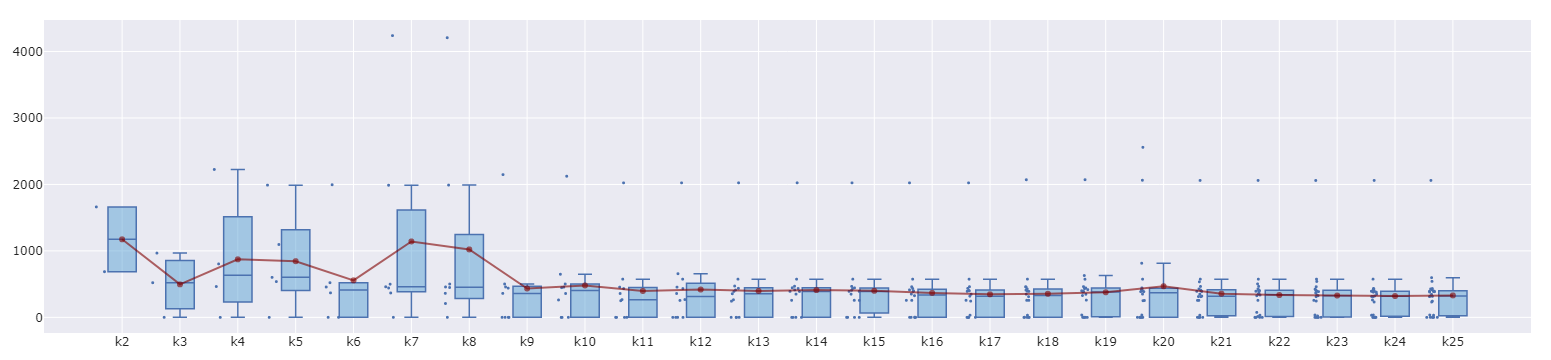

In [67]:
plot_elbow(Euclidean_centres, alg='KUMAP', mode = 'Sum_p99', line_type='w_avg')

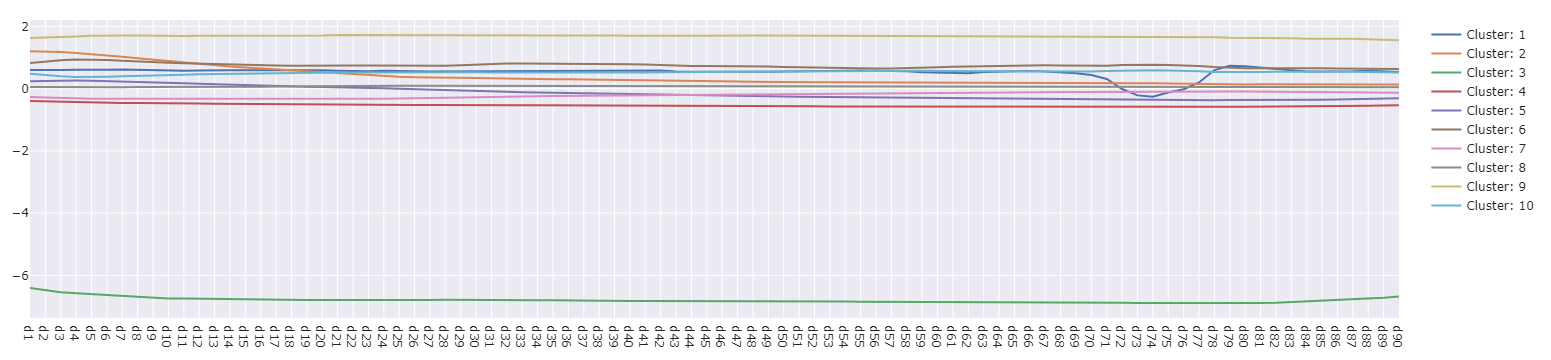

In [38]:
plot_centers(Euclidean_centres, alg='kMeans', k = 'k10')

In [39]:
('_').join(['kMeans', 'k10'])  

'kMeans_k10'

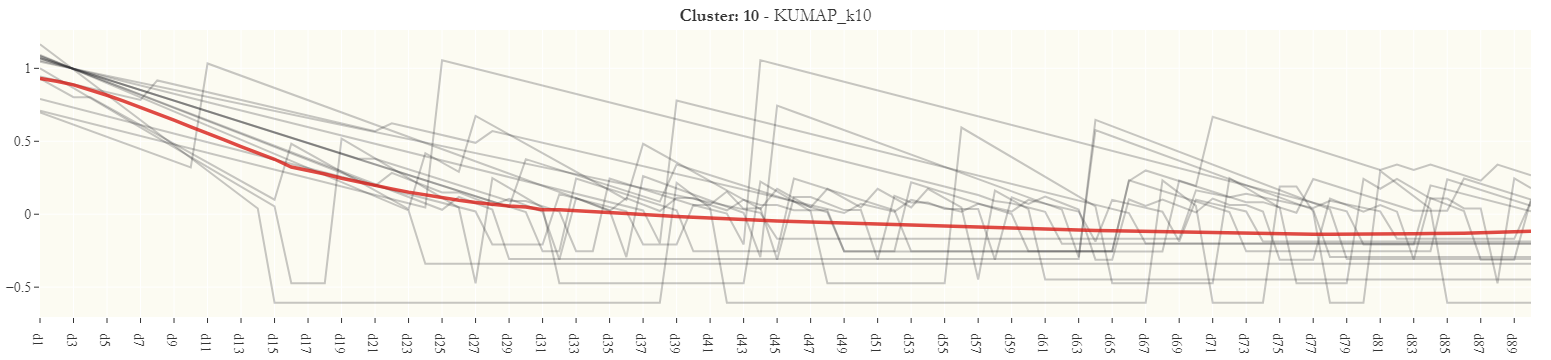

In [40]:
plot_cluster_samples(Euclidean_centres, df_data, alg = 'KUMAP', k = 'k10', cluster=10, sample=15, seed=42)

---
# DTW & *"kMedoid"*
https://dtaidistance.readthedocs.io/en/latest/modules/dtw_barycenter.html  
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-multiple-time-series

In [69]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
algorithms = []
k = []
clusters = []
n_w_cluster = []

dba_centroids = []
dtw_avg_scores = []
dtw_total_scores = []
dtw_cum_p95 = []
dtw_cum_p99 = []
dtw_p95 = []
dtw_p99 = []
dtw_qsc = []

dtai_kmedoids = []
kmedoid_total_scores = []
kmedoid_avg_scores = []
kmedoid_cum_p95 = []
kmedoid_cum_p99 = []
kmedoid_p95 = []
kmedoid_p99 = []
kmedoid_qsc = []

i = 0
for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) 

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
        i += 1
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))
        
        # Calculating DTW cluster centre
        dba_centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
        # Saving DTW cluster centre
        dba_centroids.append(dba_centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for DTW
        dtw_scores = []
        for window in sol_data:
            dtw_score = dtw_dist(dba_centroid, window)
            dtw_scores.append(dtw_score)
        dtw_total_scores.append(np.sum(np.abs(dtw_scores)))
        dtw_avg_scores.append(np.mean(np.abs(dtw_scores)))
        
        dtw_cum_p95.append(np.sum(np.where(dtw_scores <= np.percentile(dtw_scores, 95), dtw_scores, 0)))
        dtw_cum_p99.append(np.sum(np.where(dtw_scores <= np.percentile(dtw_scores, 99), dtw_scores, 0)))
        
        dtw_p95.append(np.percentile(dtw_scores, 95))
        dtw_p99.append(np.percentile(dtw_scores, 99))
        q1, q2, q3 = np.percentile(dtw_scores, [25, 50, 75])
        if q3 - q1 == 0:
            dtw_qsc.append(0)
        else:
            dtw_qsc.append((q3 + q1 - 2*q2) / (q3 - q1))

        
        
        # Identifying kMedoid
        idx_min = np.argmin(np.abs(dtw_scores))
        dtai_kmedoid = sol_data[idx_min]
        dtai_kmedoids.append(dtai_kmedoid)
        
        # Calculating Average Score for kMedoid (DTW)
        kmedoid_scores = []
        for window in sol_data:
            kmedoid_score = dtw_dist(dtai_kmedoid, window)
            kmedoid_scores.append(kmedoid_score)
        kmedoid_total_scores.append(np.sum(np.abs(kmedoid_scores)))
        kmedoid_avg_scores.append(np.mean(np.abs(kmedoid_scores)))
        
        kmedoid_cum_p95.append(np.sum(np.where(kmedoid_scores <= np.percentile(kmedoid_scores, 95), kmedoid_scores, 0)))
        kmedoid_cum_p99.append(np.sum(np.where(kmedoid_scores <= np.percentile(kmedoid_scores, 99), kmedoid_scores, 0)))
        
        kmedoid_p95.append(np.percentile(kmedoid_scores, 95))
        kmedoid_p99.append(np.percentile(kmedoid_scores, 99))
        q1, q2, q3 = np.percentile(kmedoid_scores, [25, 50, 75])
        if q3 - q1 == 0:
            kmedoid_qsc.append(0)
        else:
            kmedoid_qsc.append((q3 + q1 - 2*q2) / (q3 - q1))


        
        
DTW_centres = pd.DataFrame(dba_centroids, columns=window_cols)
DTW_centres.insert(0, "cluster", clusters)
DTW_centres.insert(0, "k", k)
DTW_centres.insert(0, "Algorithm", algorithms)
DTW_centres.insert(3, "Avg_Score", dtw_avg_scores)
DTW_centres.insert(3, "p95", dtw_p95)
DTW_centres.insert(3, "p99", dtw_p99)
DTW_centres.insert(3, "QSC", dtw_qsc)
DTW_centres.insert(3, "Sum_p95", dtw_cum_p95)
DTW_centres.insert(3, "Sum_p99", dtw_cum_p99)
DTW_centres.insert(3, "Total_Score", dtw_total_scores)
DTW_centres.insert(3, "Cluster_Size", n_w_cluster)

        
DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
DTAI_kMedoids_centres.insert(0, "cluster", clusters)
DTAI_kMedoids_centres.insert(0, "k", k)
DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
DTAI_kMedoids_centres.insert(3, "Avg_Score", kmedoid_avg_scores)
DTAI_kMedoids_centres.insert(3, "p95", kmedoid_p95)
DTAI_kMedoids_centres.insert(3, "p99", kmedoid_p99)
DTAI_kMedoids_centres.insert(3, "QSC", kmedoid_qsc)
DTAI_kMedoids_centres.insert(3, "Sum_p95", kmedoid_cum_p95)
DTAI_kMedoids_centres.insert(3, "Sum_p99", kmedoid_cum_p99)
DTAI_kMedoids_centres.insert(3, "Total_Score", kmedoid_total_scores)
DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

Total Progress:   0%|          | 0/48 [00:00<?, ?epoch/s]

kMeans_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

kMeans_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

kMeans_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

kMeans_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

kMeans_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

kMeans_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

kMeans_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

kMeans_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

kMeans_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

kMeans_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

kMeans_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

kMeans_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

kMeans_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

kMeans_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

kMeans_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

kMeans_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

kMeans_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

kMeans_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

kMeans_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

kMeans_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

kMeans_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

kMeans_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

kMeans_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

kMeans_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

KUMAP_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

KUMAP_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

KUMAP_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

KUMAP_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

KUMAP_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

KUMAP_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

KUMAP_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

KUMAP_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

KUMAP_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

KUMAP_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

KUMAP_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

KUMAP_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

KUMAP_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

KUMAP_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

KUMAP_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

KUMAP_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

KUMAP_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

KUMAP_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

KUMAP_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

KUMAP_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

KUMAP_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

KUMAP_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

KUMAP_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

KUMAP_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

## DTW

In [70]:
DTW_centres.head(9)

,Algorithm,k,cluster,Cluster_Size,Total_Score,Sum_p99,Sum_p95,QSC,p99,p95,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,10,23.532818,19.177763,19.177763,0.111291,4.265305,3.906304,...,0.416971,0.736703,0.546404,0.389571,0.857202,0.580188,0.571334,0.565204,0.536828,0.401806
1,kMeans,k2,2,10,74.876111,60.870239,60.870239,1.000000,13.962892,13.790972,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
2,kMeans,k3,1,10,18.294845,15.653981,15.653981,0.693275,2.610990,2.491495,...,0.532978,0.365228,0.320832,0.329479,0.266999,0.259050,0.191694,0.128261,0.054503,-0.451813
3,kMeans,k3,2,10,74.876111,60.870239,60.870239,1.000000,13.962892,13.790972,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
4,kMeans,k3,3,10,23.532818,19.177763,19.177763,0.111291,4.265305,3.906304,...,0.416971,0.736703,0.546404,0.389571,0.857202,0.580188,0.571334,0.565204,0.536828,0.401806
5,kMeans,k4,1,10,74.876111,60.870239,60.870239,1.000000,13.962892,13.790972,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
6,kMeans,k4,2,10,19.355928,15.478541,15.478541,0.207658,3.723221,3.106561,...,0.404693,0.257717,0.257302,0.252066,0.189731,0.094402,-0.476761,-0.364903,0.863965,0.280001
7,kMeans,k4,3,10,23.532818,19.177763,19.177763,0.111291,4.265305,3.906304,...,0.416971,0.736703,0.546404,0.389571,0.857202,0.580188,0.571334,0.565204,0.536828,0.401806
8,kMeans,k4,4,10,21.240524,18.483105,18.483105,0.498155,2.745485,2.697752,...,0.338115,0.329467,0.338115,0.329467,0.321517,0.303641,0.303641,0.198969,0.102106,-0.792133


In [ ]:
plot_elbow(DTW_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [ ]:
plot_centers(DTW_centres, alg='KUMAP', k = 'k11')

In [ ]:
plot_cluster_samples(DTW_centres, df_data, alg = 'KUMAP', k = 'k11', cluster=10, sample=15, seed=42)

## *kMedoid*

In [71]:
DTAI_kMedoids_centres.head(9)

,Algorithm,k,cluster,Cluster_Size,Total_Score,Sum_p99,Sum_p95,QSC,p99,p95,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,10,27.072573,22.198892,22.198892,0.318131,4.827112,4.640839,...,1.019053,0.977438,0.935822,0.894206,0.852591,0.810975,0.769359,0.727744,0.686128,0.644512
1,kMeans,k2,2,10,56.427277,35.016933,35.016933,1.000000,21.311367,20.915458,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
2,kMeans,k3,1,10,24.267014,20.663835,20.663835,0.133809,3.570796,3.441265,...,0.639055,0.564948,0.490841,0.416735,0.342628,0.268521,0.194414,0.120308,0.046201,-0.518747
3,kMeans,k3,2,10,56.427277,35.016933,35.016933,1.000000,21.311367,20.915458,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
4,kMeans,k3,3,10,27.072573,22.198892,22.198892,0.318131,4.827112,4.640839,...,1.019053,0.977438,0.935822,0.894206,0.852591,0.810975,0.769359,0.727744,0.686128,0.644512
5,kMeans,k4,1,10,56.427277,35.016933,35.016933,1.000000,21.311367,20.915458,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
6,kMeans,k4,2,10,26.518860,21.630537,21.630537,0.265246,4.819001,4.541712,...,0.325527,0.267597,0.209668,0.151738,0.093809,0.035879,0.383456,0.325527,0.267597,0.209668
7,kMeans,k4,3,10,27.072573,22.198892,22.198892,0.318131,4.827112,4.640839,...,1.019053,0.977438,0.935822,0.894206,0.852591,0.810975,0.769359,0.727744,0.686128,0.644512
8,kMeans,k4,4,10,25.405822,21.942725,21.942725,-0.010466,3.461671,3.455970,...,-0.724725,-0.724725,-0.724725,-0.724725,-0.724725,-0.724725,-0.724725,-0.724725,-0.724725,-0.724725


In [ ]:
plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [ ]:
plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k11')

In [ ]:
plot_cluster_samples(DTAI_kMedoids_centres, df_data, alg = 'KUMAP', k = 'k11', cluster=10, sample=15, seed=42)

---
# kMedoids  - DTW
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.clustering.k_medoids.TimeSeriesKMedoids.html#sktime.clustering.k_medoids.TimeSeriesKMedoids.fit_predict

In [ ]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in enumerate(sol_cols):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in range(c_min, c_max + 1):
#         i += 1
#         print(f'Processing {sol} ({i}/{total_c})', end='\r')
#         # print(f'\n{process}', end='\r')
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols][:100].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre
#         kMedoids = TimeSeriesKMedoids(n_clusters = 1, metric = 'dtw', max_iter = 10, tol = 0.001)
#         kMedoids_model = kMedoids.fit(sol_data)
#         centroid = kMedoids_model.cluster_centers_.ravel()
#         # Saving cluster centre
#         centroids.append(centroid)
        
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
        
        
# kMedoids_centres = pd.DataFrame(centroids, columns=window_cols)
# kMedoids_centres.insert(0, "cluster", clusters)
# kMedoids_centres.insert(0, "k", k)
# kMedoids_centres.insert(0, "Algorithm", algorithms)
# kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# kMedoids_centres.insert(3, "Total_Score", total_scores)
# kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [ ]:
# kMedoids_centres.head(9)

In [ ]:
# plot_elbow(kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [ ]:
# plot_centers(kMedoids_centres, alg='KUMAP', k = 'k10')

---
# DTAI "kMedoids"  - DTW


In [ ]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# dtai_kmedoids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
#         i += 1
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre (DTW)
#         centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
#         # Saving cluster centre
#         centroids.append(centroid)
       
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating cluster centre (kMedoid)
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         idx_min = np.argmin(np.abs(scores))
#         dtai_kmedoid = sol_data[idx_min]
#         dtai_kmedoids.append(dtai_kmedoid)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(dtai_kmedoid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
      
        
# DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
# DTAI_kMedoids_centres.insert(0, "cluster", clusters)
# DTAI_kMedoids_centres.insert(0, "k", k)
# DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
# DTAI_kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# DTAI_kMedoids_centres.insert(3, "Total_Score", total_scores)
# DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [ ]:
# DTAI_kMedoids_centres.head(9)

In [ ]:
# plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [ ]:
# plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k11')

In [ ]:
# plot_cluster_samples(DTAI_kMedoids_centres, df_data, alg = 'KUMAP', k = 'k11', cluster=1, sample=10, seed=None)

---
# Saving Results

## Euclidean

In [ ]:
solution_fileName = f'{solution_name}-Euc_Centers.csv'
solution_fileName

In [ ]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
Euclidean_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## DTW

In [ ]:
solution_fileName = f'{solution_name}-DTW_Centers.csv'
solution_fileName

In [ ]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTW_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## kMedoid(DTW)

In [ ]:
solution_fileName = f'{solution_name}-kMedoid_DTW_Centers.csv'
solution_fileName

In [ ]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTAI_kMedoids_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)